## Contexte et Motivations
-> Collecte des données
->Enjeux "métiers"

## Préparation des données et visualisation
->Data Cleaning (Jointures, Outliers)
->Corrélations, Boxplots, Histogramme ...
->Train/Test/Valid

## Benchmark de méthodes
->RandomForest
->Régression linéaire
->Boosting
->GAM
->SVM
(->Clustering)

## Discussion des résultats
->Interprétation "métier"

# Contexte et Motivations

## Collecte des données

L'ensemble des données ont été collectées via le package python statsbobmpy (openData)

In [69]:
from statsbombpy import sb
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [10]:
competitionData = sb.competitions()

/home/jcaudard17/.local/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [11]:
competitionData.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
1,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-14T05:41:27.566989,None,None,2024-02-14T05:41:27.566989
2,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
3,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
4,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [12]:
matchStats = sb.matches(competition_id=9, season_id=27)

/home/jcaudard17/.local/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [13]:
matchStats.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3890561,2016-05-14,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hoffenheim,Schalke 04,1,4,available,...,None,34,Regular Season,PreZero Arena,Felix Brych,Julian Nagelsmann,André Breitenreiter,1.1.0,2,2
1,3890505,2016-04-02,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Bayern Munich,Eintracht Frankfurt,1,0,available,...,None,28,Regular Season,Allianz Arena,Florian Meyer,Josep Guardiola i Sala,Niko Kovač,1.1.0,2,2
2,3890511,2016-04-08,20:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,Hannover 96,2,2,available,...,None,29,Regular Season,Olympiastadion Berlin,Benjamin Brand,Pál Dárdai,Daniel Stendel,1.1.0,2,2
3,3890515,2016-04-09,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hamburger SV,Darmstadt 98,1,2,available,...,None,29,Regular Season,Volksparkstadion,Peter Sippel,Bruno Labbadia,Dirk Schuster,1.1.0,2,2
4,3890411,2015-12-20,16:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,FSV Mainz 05,2,0,available,...,None,17,Regular Season,Olympiastadion Berlin,Peter Sippel,Pál Dárdai,Martin Schmidt,1.1.0,2,2


## Enjeux métiers

Objectifs : Prévisions de résultats de match de football en fonction des données des équipes (Equipes, Lineup ...)

# Préparation des données et Visualisation

## Data Cleaning

Objectifs : 
- Récup pour chaque ligue chaque match
- Pour chaque match, récup le résultats en target
- Pour chaque match, récup le nombre d'évènements à la mi-temps

In [14]:
#Sélection des colonnes utiles par match
matchStats = matchStats[['match_id', 'home_team', 'away_team', 'home_score', 'away_score']]

Prévision = Classification Home/Draw/Away

--> Création de la target

In [15]:
def result(row):
    resultLabel = ""

    if row['home_score'] > row['away_score']:
        resultLabel = "Home"

    elif row['home_score'] < row['away_score']:
        resultLabel = "Away"

    else:
        resultLabel = "Draw"

    return resultLabel


In [16]:
matchStats['Results'] = matchStats.apply(result, axis = 1)

In [17]:
matchStats.shape

(306, 6)

In [18]:
matchStats.head()

,match_id,home_team,away_team,home_score,away_score,Results
0,3890561,Hoffenheim,Schalke 04,1,4,Away
1,3890505,Bayern Munich,Eintracht Frankfurt,1,0,Home
2,3890511,Hertha Berlin,Hannover 96,2,2,Draw
3,3890515,Hamburger SV,Darmstadt 98,1,2,Away
4,3890411,Hertha Berlin,FSV Mainz 05,2,0,Home


In [19]:
#On indexe par match_id
matchStats.set_index('match_id', inplace=True)

In [92]:
#Colonnes à ajouter au Dataset
EVENT_NAMES = ["Ball Receipt*", "Ball Recovery", "Dispossessed", "Duel", "Block", "Offside", "Clearance", "Interception", "Dribble", "Shot", "Pressure", "Substitution", "Own Goal Against", "Foul Won", "Foul Committed", "Goal Keeper", "Bad Behaviour", "Player On", "Player Off", "Shield", "Pass", "50/50", "Tactical Shift", "Error", "Miscontrol", "Dribbled Past", "Injury Stoppage", "Referee Ball-Drop", "Carry"]

try:
    for matchId in matchStats.index:
        #Récupérer tout les events du matchs
        matchEventFull = sb.events(match_id = matchId)

        #Ne conserver que ceux pour lesquels period = 1 (1ere mi-temps)
        matchEventFull = matchEventFull.loc[matchEventFull['period'] == 1]

        #On compte le nombre d'occurences de chaque event par team
        eventCountByTeam = matchEventFull.groupby(by=['team', 'type'])['type'].count().unstack(level=1)

        #On récupère les noms de chaque équipe
        homeTeamName = matchStats.loc[matchId,'home_team']
        awayTeamName = matchStats.loc[matchId,'away_team']


        #On ajoute les colonnes features intéressantes au dataframe matchStats
        for name in EVENT_NAMES:
            matchStats.loc[matchId, "Home-" + name] = eventCountByTeam.loc[homeTeamName, name] if name in eventCountByTeam.loc[homeTeamName].index else 0
            matchStats.loc[matchId, "Away-" + name] = eventCountByTeam.loc[awayTeamName, name] if name in eventCountByTeam.loc[awayTeamName].index else 0
except:
    print("Oopsie !")    


Oopsie !


/home/jcaudard17/.local/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [39]:
matchStats.fillna(0, inplace= True)

In [115]:
#On crée le dataset "final"
matchStats = matchStats.iloc[:, 4:]
target = matchStats['Results']
matchStats = matchStats.iloc[:,1:].astype(int)

KeyError: 'Results'

# Data Visualization

## Idées

Corrmatrix entre variabmes

Boxplot (fonction de target)



ValueError: could not convert string to float: 'Away'

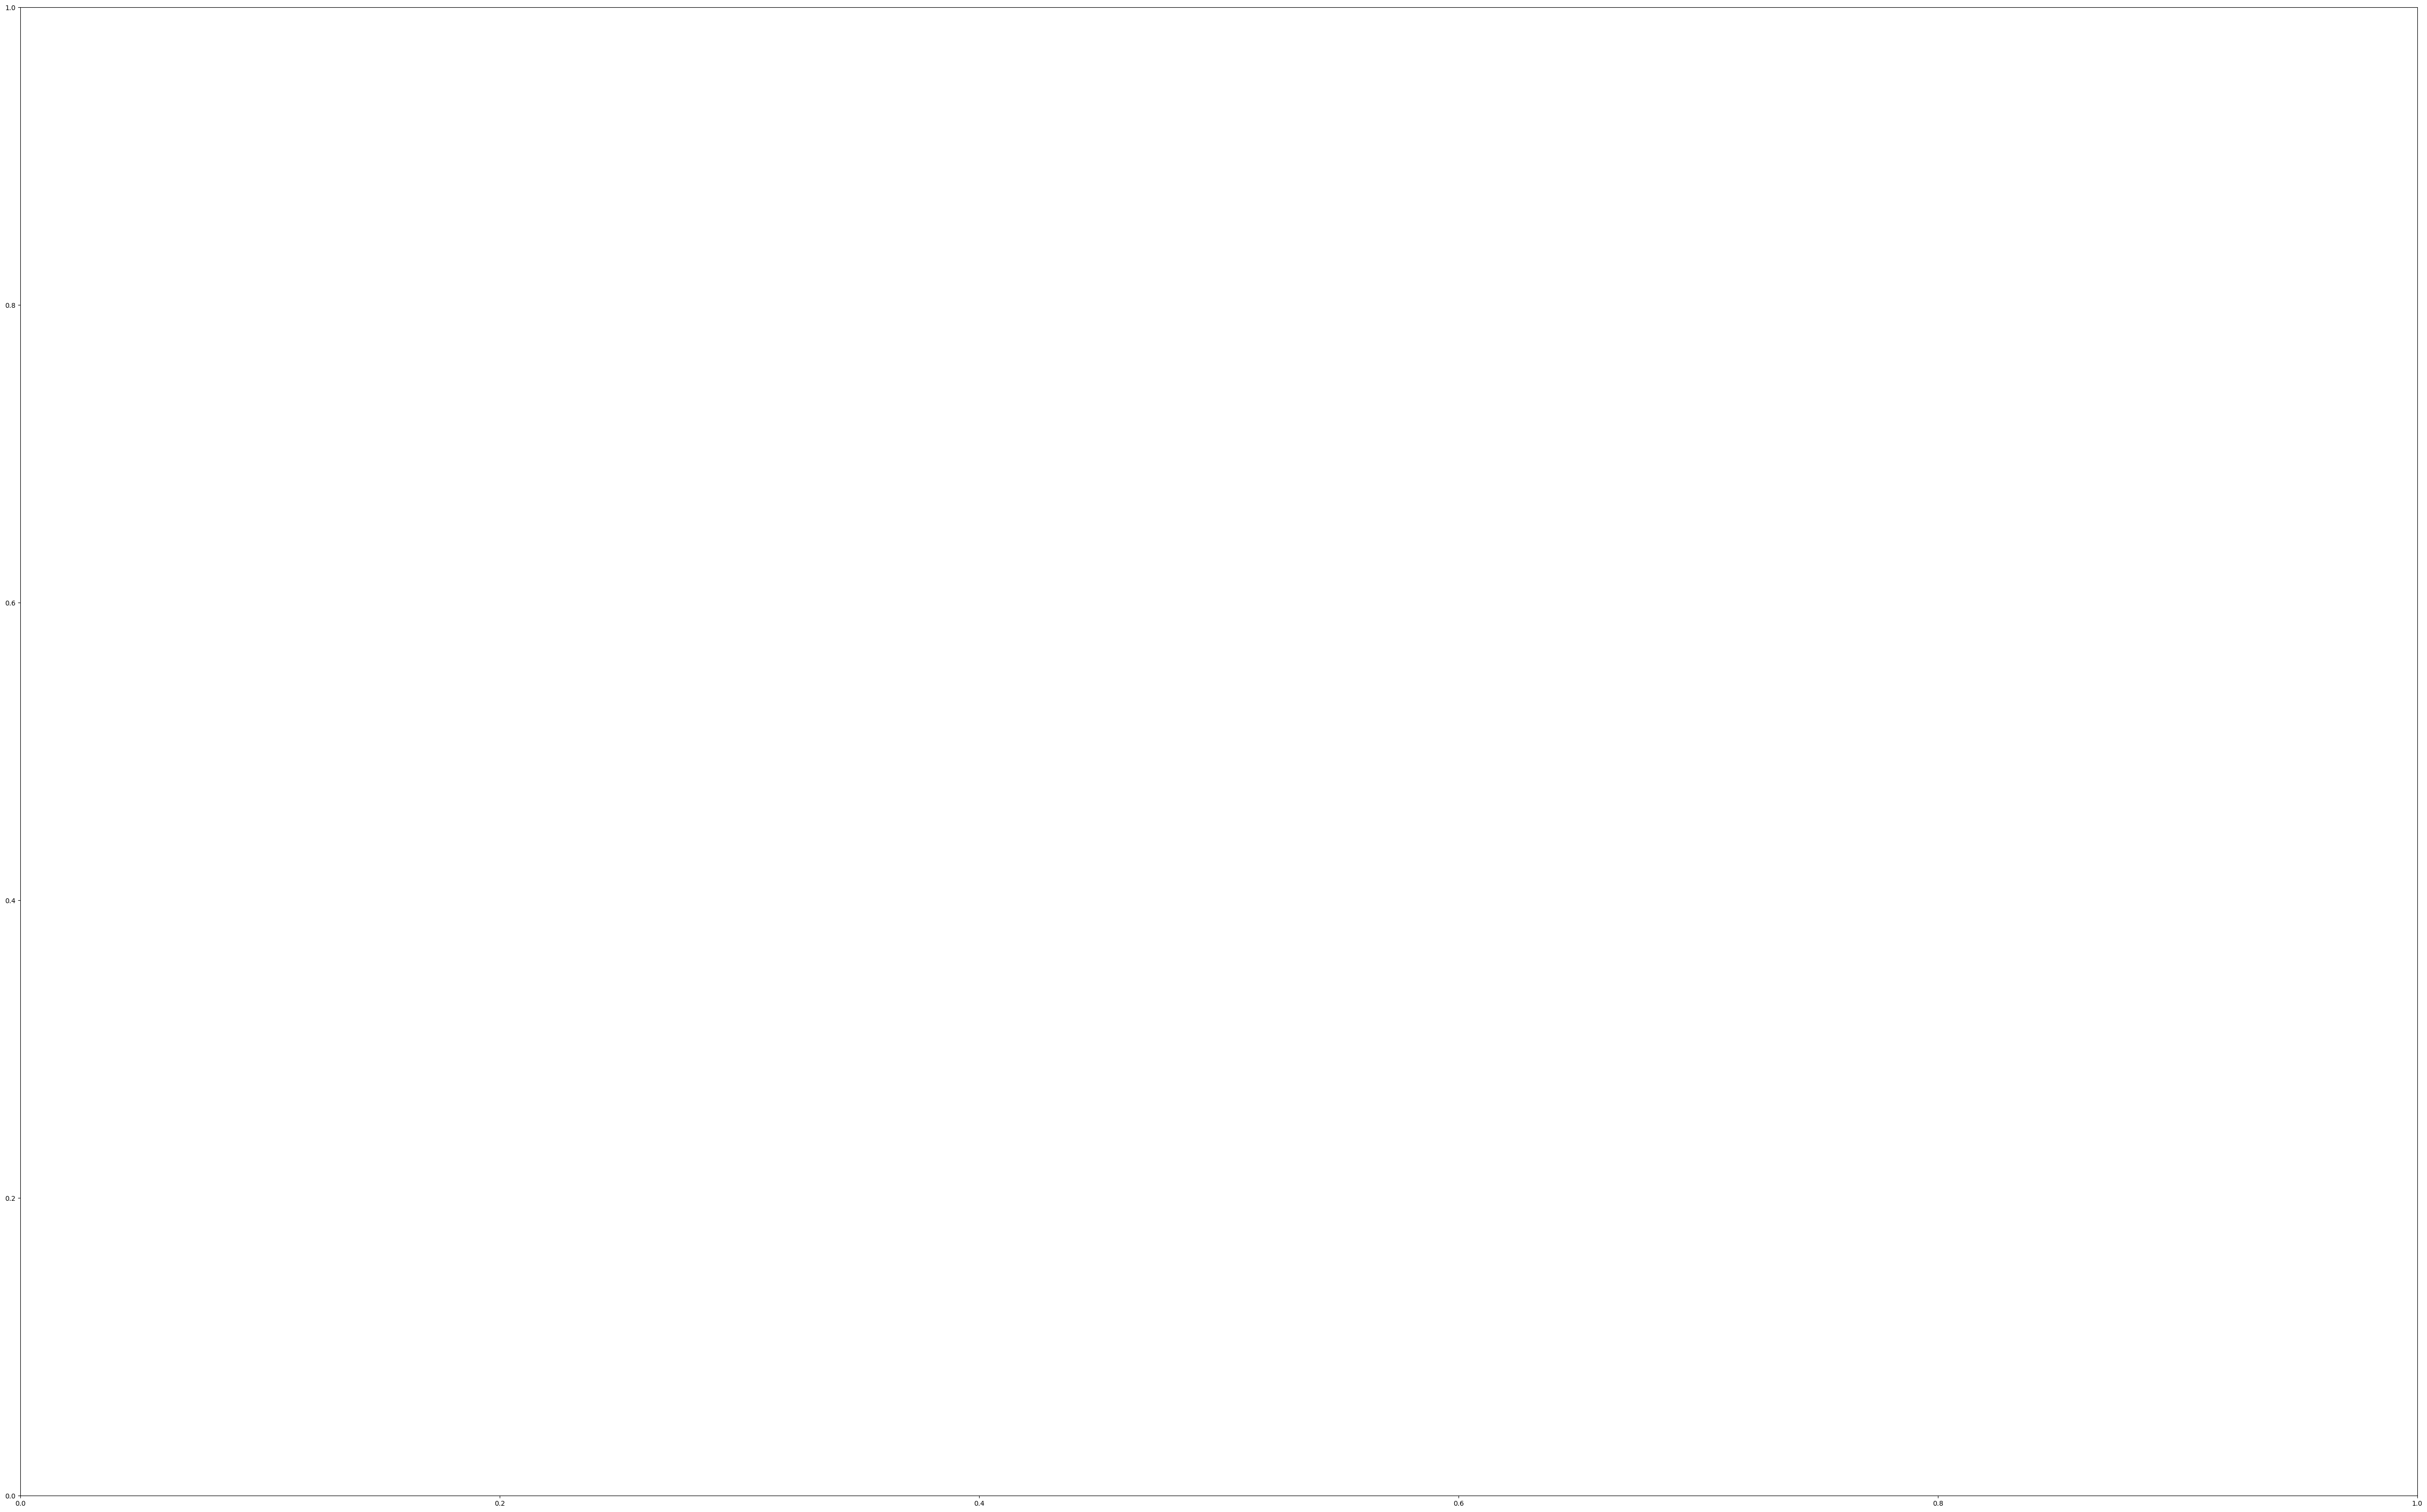

In [116]:
cMap = sns.diverging_palette(230, 20, as_cmap=True)


fig, ax = plt.subplots(figsize= (64,40))
sns.heatmap(matchStats.corr(), mask = np.triu(np.ones_like(matchStats.corr(), dtype = bool)), cmap = cMap, annot = True, linewidths = .5, vmin = -1, vmax = 1)

# Modélisation

In [146]:
xTrain, xTest, yTrain, yTest = train_test_split(matchStats.iloc[:, :-1], target, random_state=42)

# PCA

In [144]:
pca = decomposition.PCA()
scl = StandardScaler()

pca.fit(scl.fit_transform(xTrain))

PCA()

Text(0, 0.5, 'Cumulative explained variance')

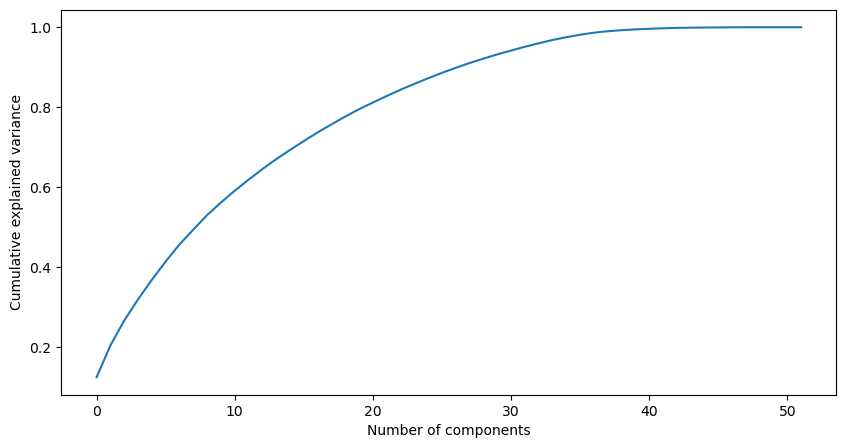

In [145]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

## Modèles

Idées : 
LogisticRegression
RandomForest


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn import (
    datasets,
    decomposition,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)

In [138]:
###RandomForest Pipeline

from sklearn.ensemble import RandomForestClassifier

pipeRandomForest = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', RandomForestClassifier())
])

In [148]:
###SVC Pipeline

from sklearn.svm import SVC

pipeSVC = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC())
])

In [154]:
###Logistic Regression Pipeline

from sklearn.linear_model import LogisticRegression

pipeLogisticRegression = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression())
])

In [156]:
###Gradient Boosting Classifier Pipeline

from sklearn.ensemble import GradientBoostingClassifier

pipeGradientBoosting = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', GradientBoostingClassifier())
])

In [153]:
###XGBoost Classifier Pipeline

import xgboost as xgb

pipeXGBoost = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', xgb.XGBClassifier(objective = 'multi:softmax', random_state=42))
])

In [160]:
models = {
    'Random Forest Classifier': pipeRandomForest,
    'SVC': pipeSVC,
    'Logistic Regression': pipeLogisticRegression,
    'Gradient Boosting Classifier': pipeGradientBoosting
    #'XGBoost Classifier' : pipeXGBoost
}

In [166]:
models_scores = [] ###list of model names + score

for idx, (name,model) in enumerate(models.items()):
    ###fitting model on the training set and computing the accuracy score
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = metrics.accuracy_score(y_pred, y_test)

    models_scores.append((name, score))

    sorted_models = sorted(models_scores, key=lambda x: x[1], reverse=True)

In [167]:
for rank, (model_names, score) in enumerate(sorted_models, start=1):
    print('\nRank #%s :' % rank)
    print('Estimator: %s' % model_names)
    print('Test set accuracy score for default params: %.3f ' % score)


Rank #1 :
Estimator: Logistic Regression
Test set accuracy score for default params: 0.571 

Rank #2 :
Estimator: Random Forest Classifier
Test set accuracy score for default params: 0.468 

Rank #3 :
Estimator: SVC
Test set accuracy score for default params: 0.442 

Rank #4 :
Estimator: Gradient Boosting Classifier
Test set accuracy score for default params: 0.377 


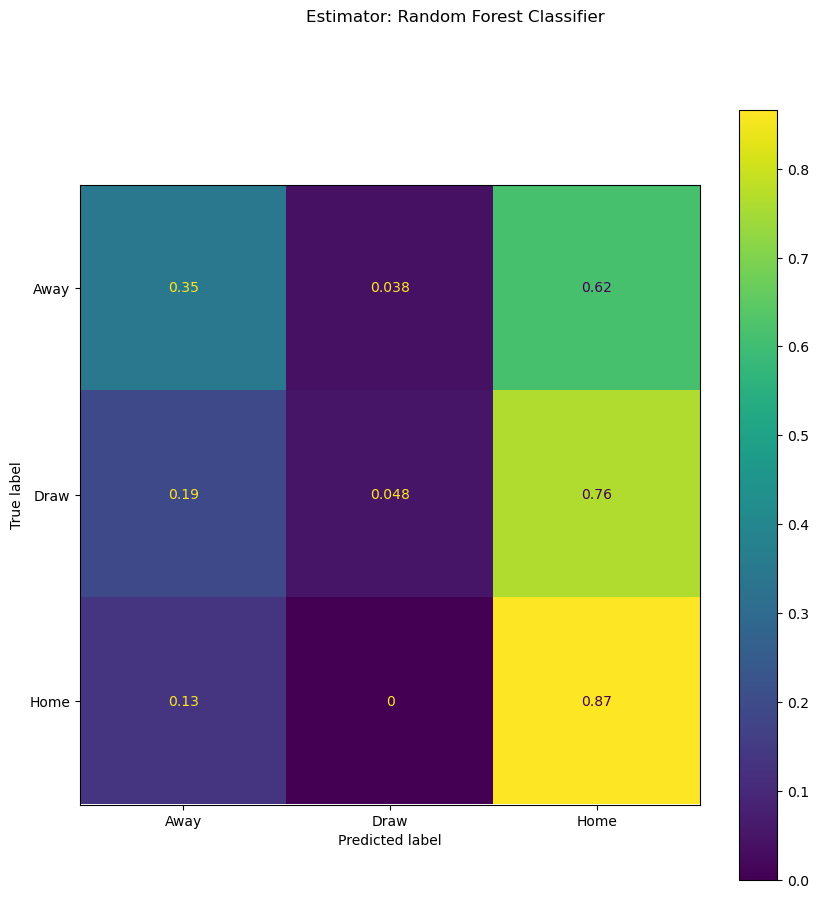

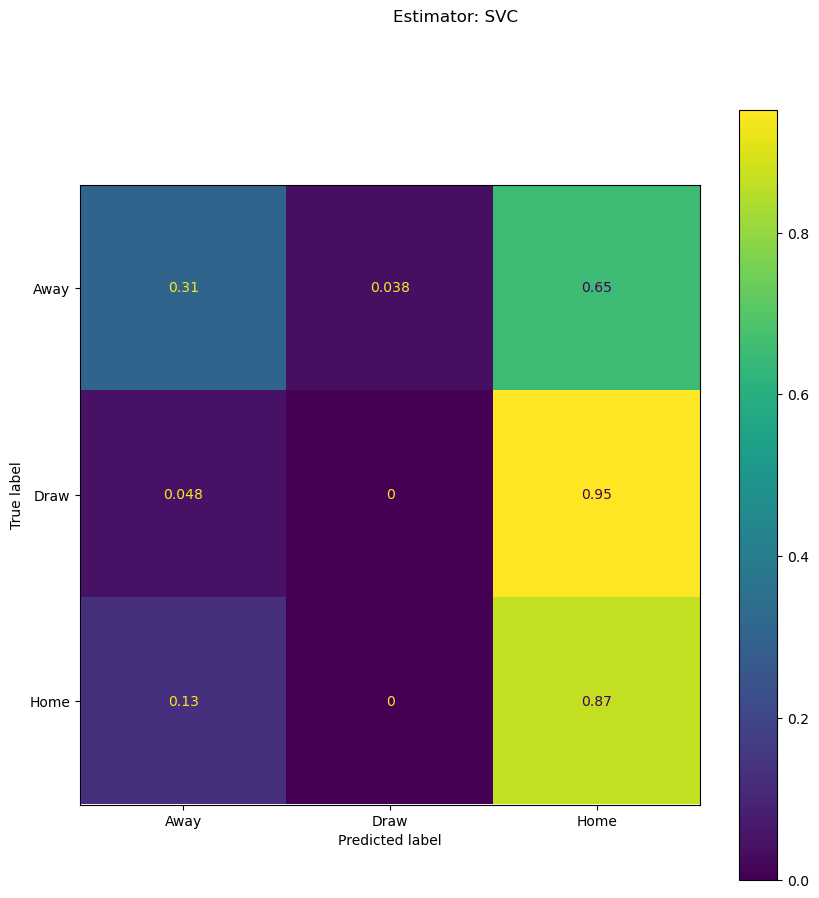

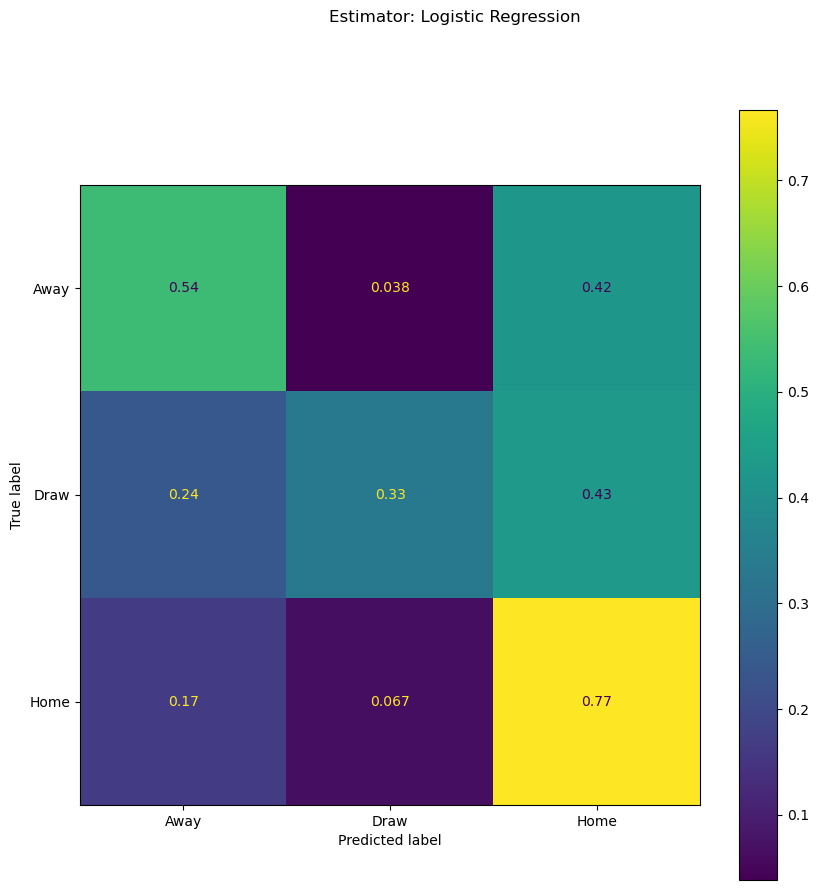

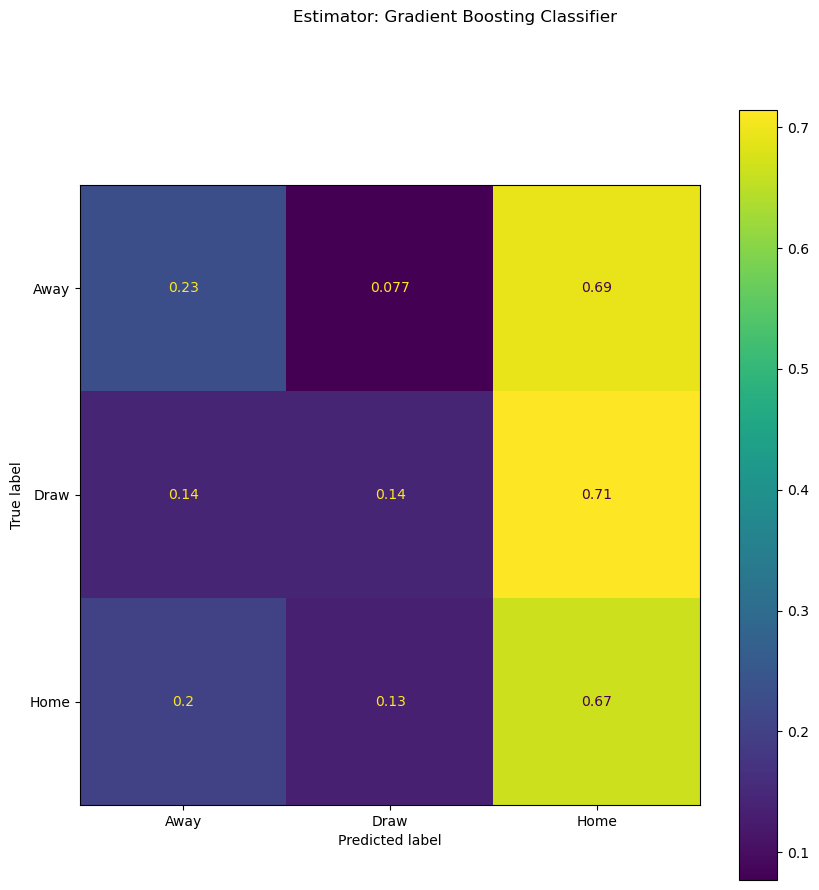

In [172]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

for idx, (name,model) in enumerate(models.items()):
    fig,ax = plt.subplots(figsize=(10,10))
    yPred = model.predict(xTest)
    fig.suptitle('Estimator: %s' % name)
    ConfusionMatrixDisplay.from_predictions(yTest, yPred, ax=ax, normalize= 'true')

## Métriques et résultats

CrossEntropyLoss

# Trucs à faire

    Boucle sur Compétitions pour créer dataframe plus gros

## Créer csv avec dataframe

Description des variables : 

Visualiaztion : Choix + Explication des Boxplots, Correlation matrix, 

Modèles : XGBoost/RandomForest/LogisticRegression

Métriques : accuracy_score, balanced_accuracy

TUning : Gridsearch/RandomizedSearch sur params

In [175]:
matchStats['target'].value_counts()

target
Home    135
Away    100
Draw     71
Name: count, dtype: int64